# Medical Insurance Premium Prediction

Predict the health insurance cost incurred by individuals based on the features: age, gender, body mass, index, number of children, geolocation, and smoking habits.

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from pathlib import Path
# from jupyterthemes import jtplot
# jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False) 


dataset_path = Path.cwd() / "datasets"

df = pd.read_csv(dataset_path / "insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### Exploratory Data Analysis

<Axes: >

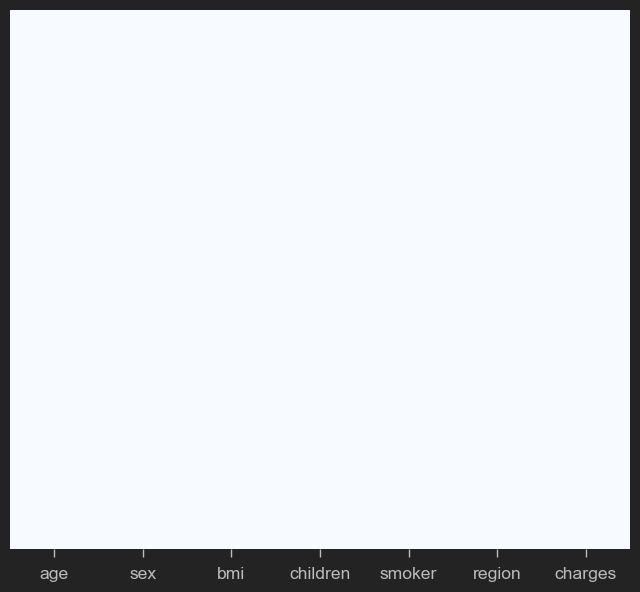

In [73]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")

#### Note: We do not have any missing element

In [74]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [75]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [76]:
df_region = df.groupby(by='region').mean(numeric_only=True) # Add this numeric_only argument to prevent from getting an error.

df_region

,age,bmi,children,charges
region,,,,
northeast,39.268519,29.173503,1.046296,13406.384516
northwest,39.196923,29.199785,1.147692,12417.575374
southeast,38.939560,33.355989,1.049451,14735.411438
southwest,39.455385,30.596615,1.141538,12346.937377


#### Group data by age

In [77]:
df_age = df.groupby(by='age').mean(numeric_only=True)
df_age

,bmi,children,charges
age,,,
18,31.326159,0.449275,7086.217556
19,28.596912,0.426471,9747.909335
20,30.632759,0.862069,10159.697736
21,28.185714,0.785714,4730.464330
22,31.087679,0.714286,10012.932802
23,31.454464,1.000000,12419.820040
24,29.142679,0.464286,10648.015962
25,29.693929,1.285714,9838.365311
26,29.428929,1.071429,6133.825309


In [78]:
df['sex'].unique()

array(['female', 'male'], dtype=object)

##### Convert Categorical variable to numerical

In [79]:
df['sex'] = df['sex'].apply(lambda x: 0 if x=='female' else 1)

In [80]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520


In [81]:
df['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [82]:
df['smoker']= df['smoker'].apply(lambda x: 0 if x == 'no' else 1)

In [83]:
region_dummies = pd.get_dummies(df['region'], drop_first = True, dtype=int)

In [84]:
region_dummies

,northwest,southeast,southwest
0,0,0,1
1,0,1,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
1333,1,0,0
1334,0,0,0
1335,0,1,0
1336,0,0,1


In [85]:
insurance_df = pd.concat([df, region_dummies], axis=1)

In [86]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges,northwest,southeast,southwest
0,19,0,27.900,0,1,southwest,16884.92400,0,0,1
1,18,1,33.770,1,0,southeast,1725.55230,0,1,0
2,28,1,33.000,3,0,southeast,4449.46200,0,1,0
3,33,1,22.705,0,0,northwest,21984.47061,1,0,0
4,32,1,28.880,0,0,northwest,3866.85520,1,0,0


In [87]:
insurance_df.drop(['region'], axis = 1, inplace = True)

In [88]:
insurance_df.head()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0


#### Perform Data Visualization

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'children'}>],
       [<Axes: title={'center': 'smoker'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

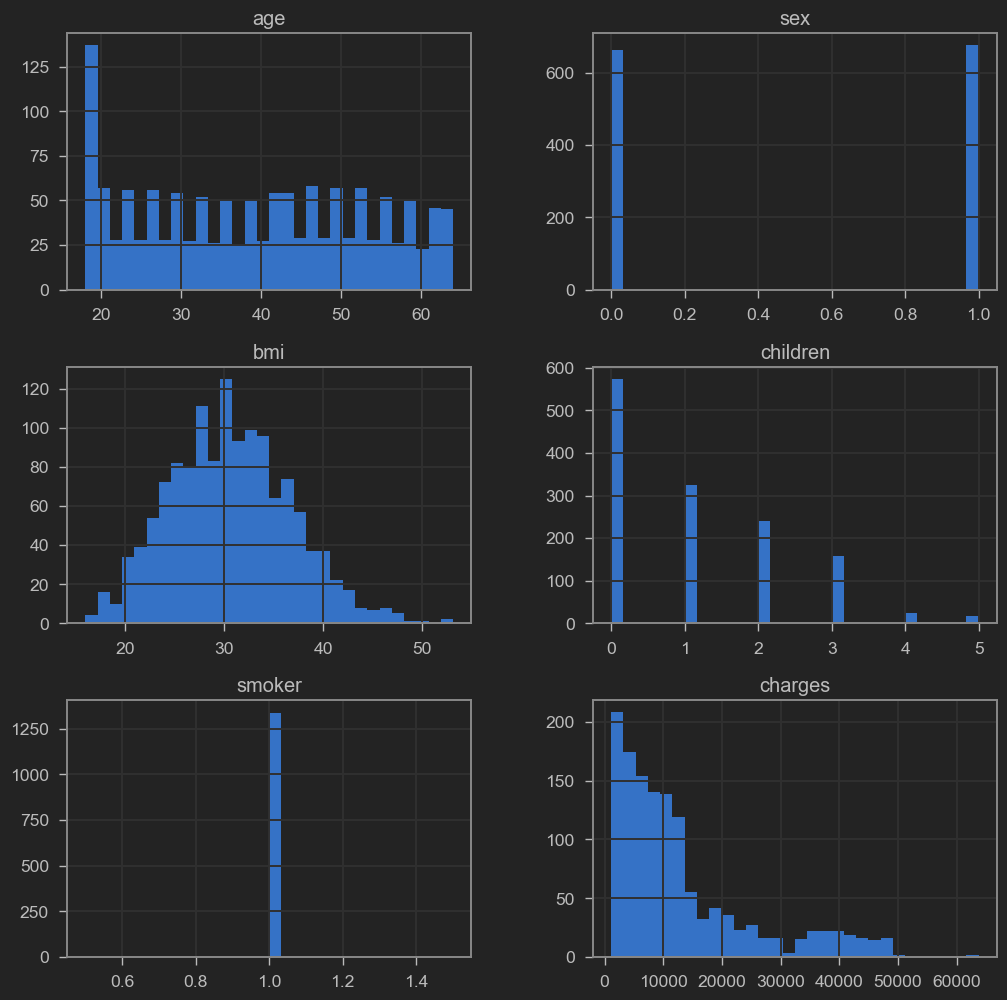

In [62]:
insurance_df[['age', 'sex', 'bmi','children','smoker','charges']].hist(bins=30, figsize=(12,12))

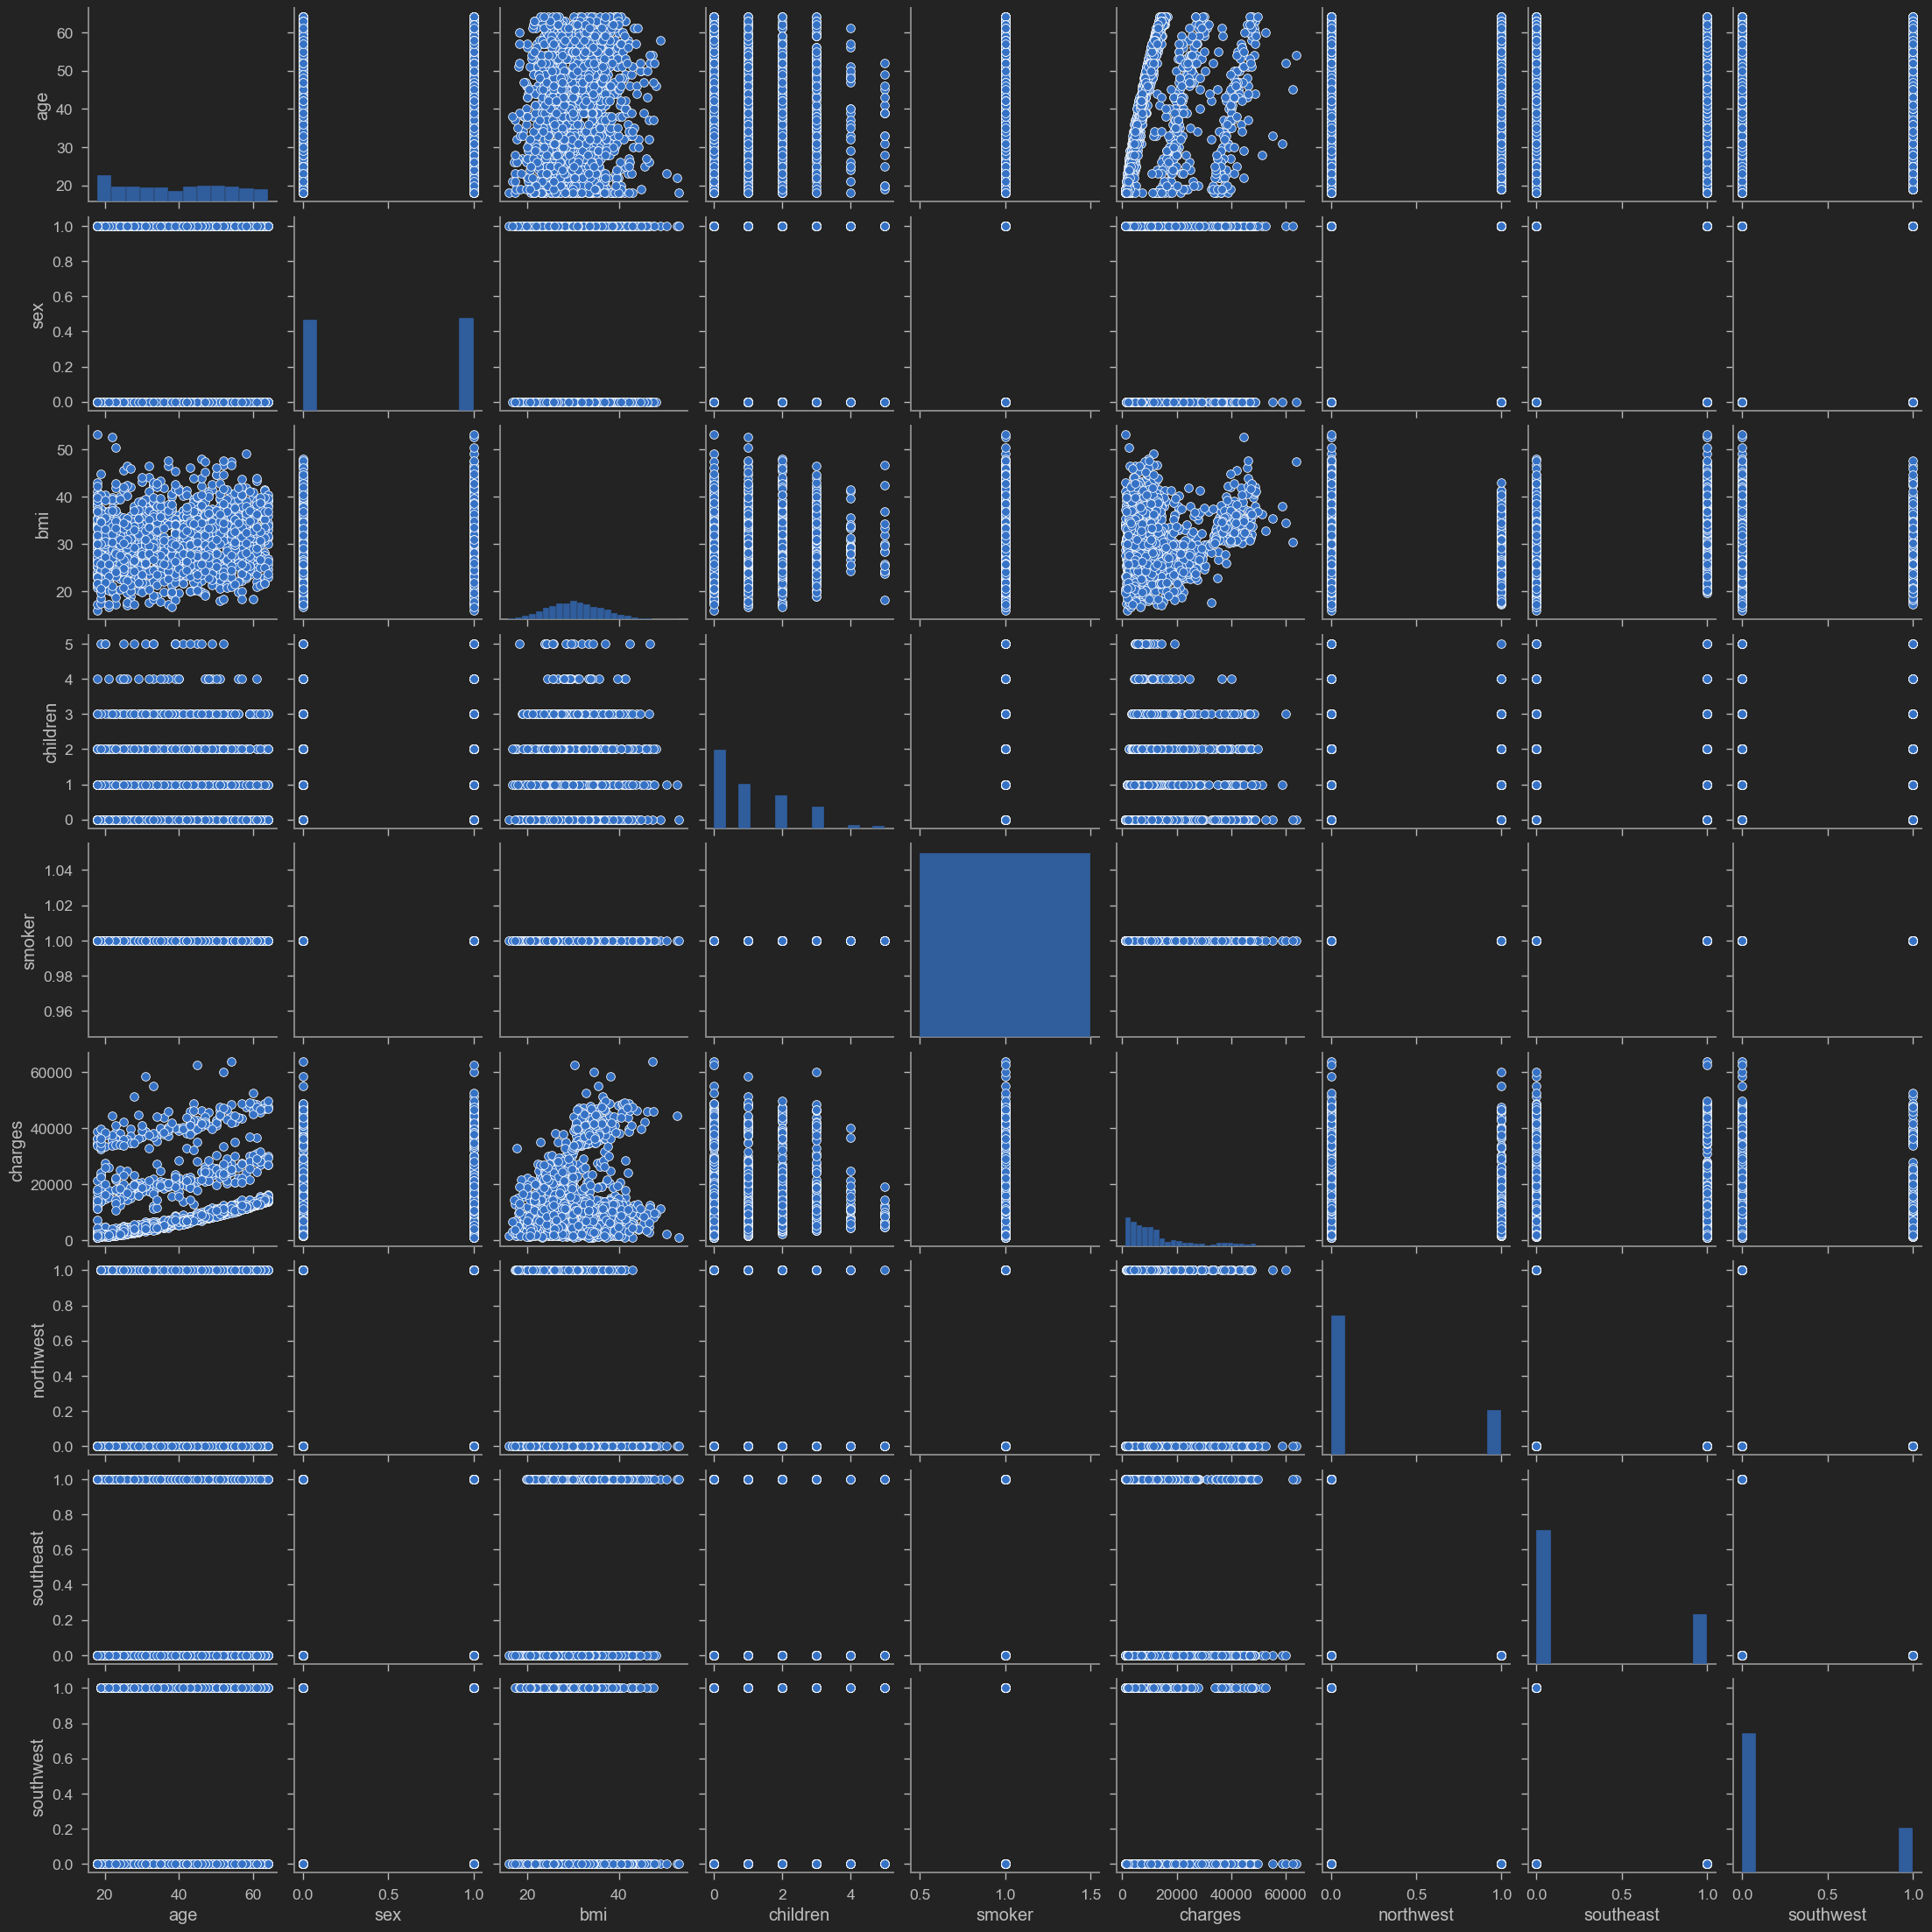

In [63]:
sns.pairplot(insurance_df)

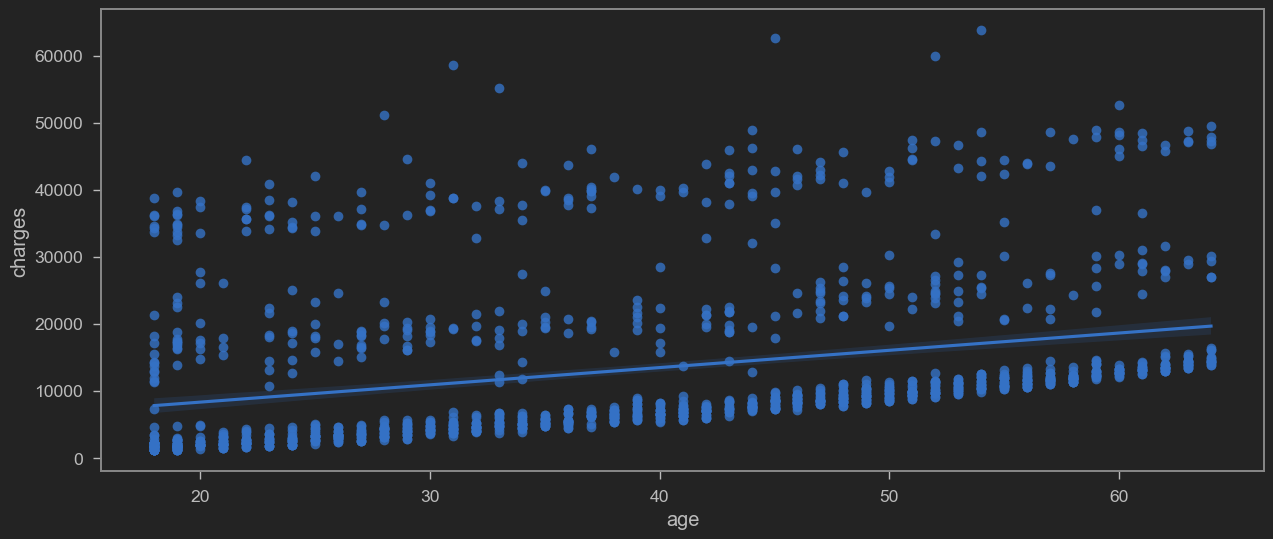

In [64]:
plt.figure(figsize=(15,6))
sns.regplot(x = 'age', y = 'charges', data = insurance_df)
plt.show()

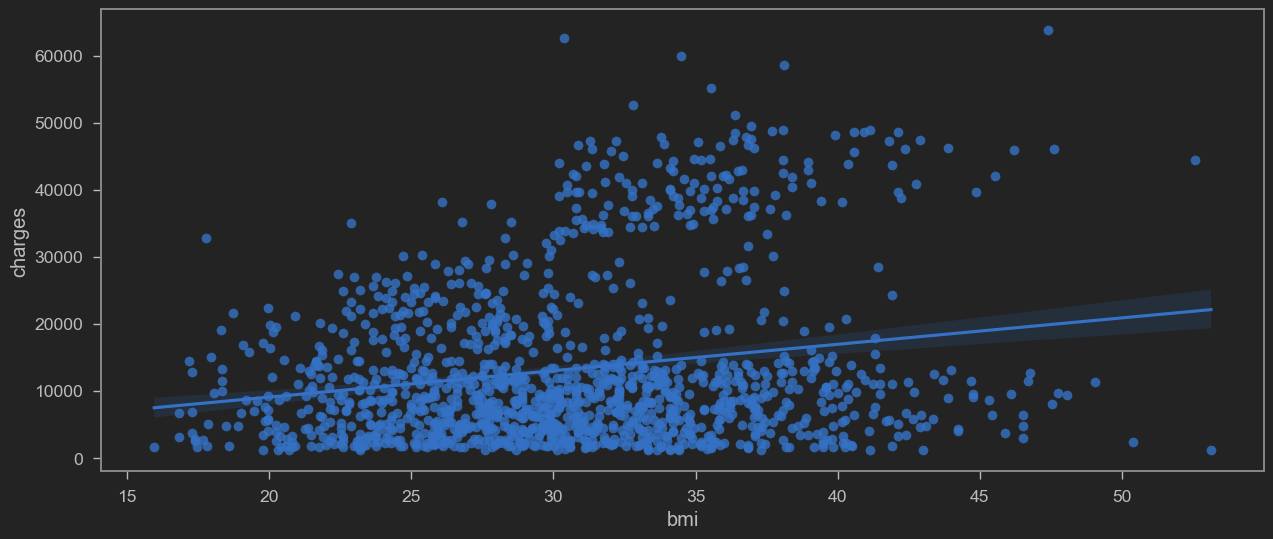

In [65]:
plt.figure(figsize = (15, 6))
sns.regplot(x = 'bmi', y = 'charges', data = insurance_df)
plt.show()

#### Calculate and plot the correlation matrix

In [89]:
insurance_df.corr()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.299008,-0.000407,-0.011642,0.010016
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.057292,-0.011156,0.017117,-0.004184
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.198341,-0.135996,0.270025,-0.006205
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.067998,0.024806,-0.023066,0.021914
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,0.787251,-0.036945,0.068498,-0.036945
charges,0.299008,0.057292,0.198341,0.067998,0.787251,1.000000,-0.039905,0.073982,-0.043210
northwest,-0.000407,-0.011156,-0.135996,0.024806,-0.036945,-0.039905,1.000000,-0.346265,-0.320829
southeast,-0.011642,0.017117,0.270025,-0.023066,0.068498,0.073982,-0.346265,1.000000,-0.346265
southwest,0.010016,-0.004184,-0.006205,0.021914,-0.036945,-0.043210,-0.320829,-0.346265,1.000000


<Axes: >

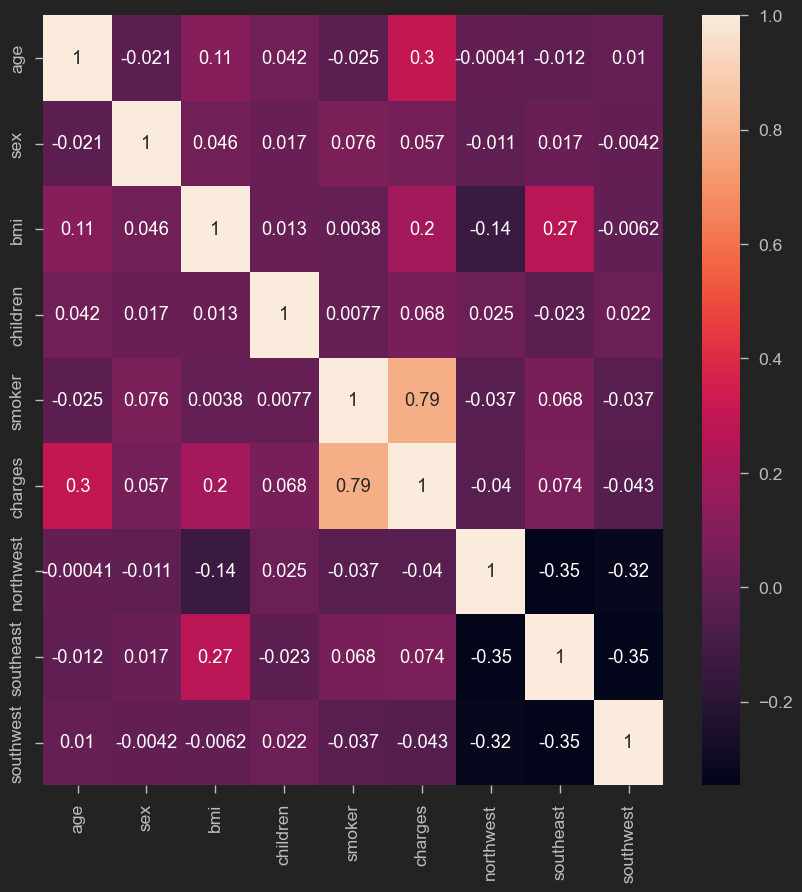

In [91]:
plt.figure(figsize=(10,10))
sns.heatmap(insurance_df.corr(), annot=True)

#### Prepare Training and Testing Dataset

In [92]:
insurance_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'northwest',
       'southeast', 'southwest'],
      dtype='object')

In [93]:
X = insurance_df.drop(columns=['charges'])
y = insurance_df['charges']

In [97]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')
y = y.reshape(-1,1)

In [98]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)


#### Split the data into 20% Testing and 80% Training

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

#### Train and Evaluate a Linear Regression

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

regresssion_model_sklearn = LinearRegression()
regresssion_model_sklearn.fit(X_train, y_train)


LinearRegression()

In [104]:
regresssion_model_sklearn_accuracy = regresssion_model_sklearn.score(X_test, y_test)
regresssion_model_sklearn_accuracy

0.6953286617446484

In [105]:
y_predict = regresssion_model_sklearn.predict(X_test)

In [111]:
y_predict_orig = scaler_y.inverse_transform(y_predict)
y_test_orig = scaler_y.inverse_transform(y_test)

In [107]:
k = X_test.shape[1]
n = len(X_test)
n

268

In [108]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt


RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_predict_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_predict_orig)
MAE = mean_absolute_error(y_test_orig, y_predict_orig)
r2 = r2_score(y_test_orig, y_predict_orig)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 6536.847 
MSE = 42730370.0 
MAE = 4555.099 
R2 = 0.6953286762768424 
Adjusted R2 = 0.6859179790189842


#### Train and evaluate an Artificial Neural Network-based regression model

##### Next step is to train in ANN

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
ANN_model = keras.Sequential()
ANN_model.add(Dense(50, input_dim = 8))
ANN_model.add(Activation('relu'))
ANN_model.add(Dense(150))
ANN_model.add(Activation('relu'))
ANN_model.add(Dense(150))
ANN_model.add(Activation('relu'))
ANN_model.add(Dense(50))
ANN_model.add(Activation('linear'))
ANN_model.add(Dense(1))
ANN_model.compile(loss = 'mse', optimizer = 'adam')
ANN_model.summary()

e:\Python\2024_machine_learning_projects\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │         7,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,351 (149.81 KB)

 Trainable params: 38,351 (149.81 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
ANN_model.compile(optimizer='Adam', loss='mean_squared_error')
epochs_hist = ANN_model.fit(X_train, y_train, epochs=100, batch_size=20, validation_split=0.2)

NameError: name 'X_train' is not defined